## 机器学习工程师纳米学位毕业项目

作者 meelo

### 加载经过预处理的数据

In [1]:
from __future__ import print_function
from six.moves import cPickle as pickle

pickle_file = 'svhn_single.pickle'

with open(pickle_file, 'rb') as f:
    dataset = pickle.load(f)
    train_dataset = dataset['train_dataset']
    train_labels = dataset['train_labels']
    valid_dataset = dataset['valid_dataset']
    valid_labels = dataset['valid_labels']
    test_dataset = dataset['test_dataset'][:10000]
    test_labels = dataset['test_labels'][:10000]
    del dataset
    
print('Training dataset shape: ', train_dataset.shape)
print('Training labels shape: ', train_labels.shape)
print('Validing dataset shape: ', valid_dataset.shape)
print('Validing labels shape: ', valid_labels.shape)
print('Testing dataset shape: ', test_dataset.shape)
print('Testing labels shape: ', test_labels.shape)

Training dataset shape:  (72525, 32, 32)
Training labels shape:  (72525,)
Validing dataset shape:  (732, 32, 32)
Validing labels shape:  (732,)
Testing dataset shape:  (10000, 32, 32)
Testing labels shape:  (10000,)


In [2]:
import resource
print("{} Kb".format(resource.getrusage(resource.RUSAGE_SELF).ru_maxrss))

2001732 Kb


### 将数据修改成适合TensorFlow的格式

- 卷积要求图片数据的形状为(宽度×高度×通道数)
- 图片的标签需要进行1-hot编码，并转换成浮点数


![](./images/onehot.png)

In [3]:
print(train_labels[100:110])

[ 9  9  5  3  2  4  5 10  2  1]


在原始数据中，数字1-9的标签是1-9，而数字0的标签是10。为了确保1-hot编码，表示是否为0的标签在第1列，应当使用语句`np.array([10,1,2,3,4,5,6,7,8,9]) == labels`。

将10替换成0
不然argmax不对应

In [4]:
IMAGE_SIZE = 32
NUM_LABELS = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, IMAGE_SIZE, IMAGE_SIZE, num_channels)).astype(np.float32)
    #labels = (np.array([10,1,2,3,4,5,6,7,8,9]) == labels).astype(np.float32) # one-hot encoding
    labels[labels==10] = 0
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (72525, 32, 32, 1) (72525,)
Validation set (732, 32, 32, 1) (732,)
Test set (10000, 32, 32, 1) (10000,)


truncated normal  
soft max  
cross entroy loss  
regularizers  
learning rate decay
训练时dropout  
sparse  
随机梯度下降 Momumtum  
部分加载数据

In [15]:
BATCH_SIZE = 64
PATCH_SIZE = 5
DEPTH_1 = 8
DEPTH_2 = 16
DEPTH_3 = 32
NUM_HIDDEN = 64
SEED = 42

import tensorflow as tf

# BATCH_SIZE * 32 * 32 * 1
# conv1: 5 * 5 * 1 * 8
# BATCH_SIZE * 16 * 16 * 8
# conv2: 5 * 5 * 8 * 16
# BATCH_SIZE * 8 * 8 * 16
# conv3: 5 * 5 * 16 * 32
# BATCH_SIZE * 4 * 4 * 32
# fc1: 512 * 64
# BATCH_SIZE * 64
# fc2: 64 * 10 
# BATCH_SIZE * 10

graph = tf.Graph()
with graph.as_default():
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, num_channels))
    tf_train_labels = tf.placeholder(tf.int64, shape=(BATCH_SIZE,))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_valid_labels = tf.constant(valid_labels, dtype=tf.int64)
    tf_test_dataset = tf.constant(test_dataset)
    tf_test_labels = tf.constant(test_labels, dtype=tf.int64)
    
    conv1_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, num_channels, DEPTH_1], stddev=0.1))
    conv1_biases = tf.Variable(tf.zeros([DEPTH_1]))
    conv2_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_1, DEPTH_2], stddev=0.1))
    conv2_biases = tf.Variable(tf.zeros([DEPTH_2]))
    conv3_weights = tf.Variable(tf.truncated_normal([PATCH_SIZE, PATCH_SIZE, DEPTH_2, DEPTH_3], stddev=0.1))
    conv3_biases = tf.Variable(tf.zeros([DEPTH_3]))
    fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE//8 * IMAGE_SIZE//8 * DEPTH_3, NUM_HIDDEN], stddev=0.1))
    fc1_biases = tf.Variable(tf.constant(1.0, shape=[NUM_HIDDEN]))
    fc2_weights = tf.Variable(tf.truncated_normal([NUM_HIDDEN, NUM_LABELS], stddev=0.1))
    fc2_biases = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]))
    
    saver = tf.train.Saver(tf.trainable_variables()) # defaults to saving all variables
    
    def model(data, train=False):
        conv = tf.nn.conv2d(data, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, conv3_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_biases))
        pool = tf.nn.max_pool(relu, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        reshape = tf.reshape(pool, [shape[0], shape[1]*shape[2]*shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
        if train:
            hidden = tf.nn.dropout(hidden, 0.8, seed=SEED)
        return tf.matmul(hidden, fc2_weights) + fc2_biases
    
    def accuracy(predictions, labels):
        return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predictions, 1), labels), 'float')) * 100
    
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    regularizers = tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) + tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases)
    loss += 5e-4 * regularizers
    
    batch = tf.Variable(0, dtype=tf.float32)
    #decayed_learning_rate = learning_rate *
    #                    decay_rate ^ (global_step / decay_steps)
    learning_rate = tf.train.exponential_decay(
        0.01, # Base learning rate
        batch * BATCH_SIZE, # Current index into the dataset
        train_labels.shape[0]/2, # Decay step
        0.95, # Decay rate,
        staircase=True
    )
    
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(loss, global_step=batch)
    
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
    train_accuracy = accuracy(train_prediction, tf_train_labels)
    valid_accuracy = accuracy(valid_prediction, tf_valid_labels)
    test_accuracy = accuracy(test_prediction, tf_test_labels)

定义参数

In [7]:
flags = tf.app.flags
FLAGS = flags.FLAGS

flags.DEFINE_boolean('training', True, 'If true do the training else load already trained model.')
flags.DEFINE_string('checkpoint_dir', 'model/', 'Checkpoint directory')

训练后期，loss及准确率波动较大，应当使用学习率exponential decay

### 最佳模型
Validation accuracy: 83.5%  
Test accuracy: 82.5%

Validation accuracy: 88.1%  
Test accuracy: 87.6%

Validation accuracy: 90.8%
Test accuracy: 88.2%

训练集使用过一次之后，随机打乱

In [ ]:
import time
import datetime

num_steps = 10001

FLAGS.training = True

train_accuracies = []
valid_accuracies = []

start_time = time.time()
with tf.Session(graph=graph) as session:
    if FLAGS.training:
        tf.initialize_all_variables().run()
        print('Initialized')
        for step in range(num_steps):
            offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
            batch_data = train_dataset[offset:(offset + BATCH_SIZE), :, :, :]
            batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, lr, train_acc, valid_acc = \
                session.run([optimizer, loss, learning_rate, train_accuracy, valid_accuracy], feed_dict=feed_dict)
            if (step % 50 == 0):
                elapsed_time = time.time() - start_time
                start_time = time.time()
                print('Minibatch loss at step %d: %f, learning rate: %.6f, %.3f s' % (step, l, lr, elapsed_time))
                train_accuracies.append(train_acc)
                print('Minibatch accuracy: %.1f%%' % train_accuracies[-1])
                valid_accuracies.append(valid_acc)
                print('Validation accuracy: %.1f%%' % valid_accuracies[-1])
        saver.save(session, 'single.ckpt', write_meta_graph=False)
    else:
        saver.restore(session, 'single.ckpt')
    #predictions = test_prediction.eval()
    print('Test accuracy: %.1f%%' % test_accuracy.eval())

Initialized
Minibatch loss at step 0: 2.592815, learning rate: 0.010000, 0.9 ms
Minibatch accuracy: 12.5%
Validation accuracy: 22.3%
Minibatch loss at step 50: 2.249952, learning rate: 0.010000, 29.9 ms
Minibatch accuracy: 32.8%
Validation accuracy: 22.3%
Minibatch loss at step 100: 2.318143, learning rate: 0.010000, 29.5 ms
Minibatch accuracy: 20.3%
Validation accuracy: 23.6%
Minibatch loss at step 150: 2.203579, learning rate: 0.010000, 30.1 ms
Minibatch accuracy: 28.1%
Validation accuracy: 22.5%
Minibatch loss at step 200: 2.127819, learning rate: 0.010000, 33.2 ms
Minibatch accuracy: 31.2%
Validation accuracy: 30.3%
Minibatch loss at step 250: 1.961714, learning rate: 0.010000, 31.9 ms
Minibatch accuracy: 32.8%
Validation accuracy: 42.2%
Minibatch loss at step 300: 1.384231, learning rate: 0.010000, 32.1 ms
Minibatch accuracy: 50.0%
Validation accuracy: 45.2%
Minibatch loss at step 350: 1.113031, learning rate: 0.010000, 32.4 ms
Minibatch accuracy: 57.8%
Validation accuracy: 60.8%


### 学习曲线

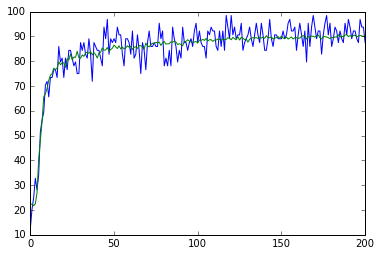

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_accuracy)
plt.plot(valid_accuracy)

### 混淆矩阵

In [8]:
def confusionMatrix(labels, predictions):
    confusions = np.zeros([10, 10], np.float32)
    for actual, predicted in zip(labels, predictions):
        confusions[actual][predicted] += 1
    return confusions

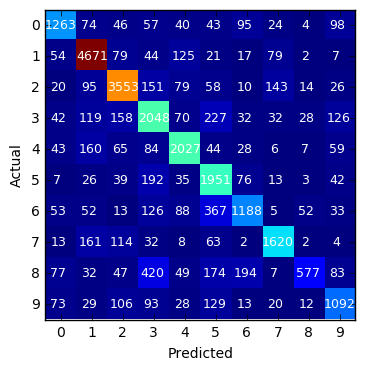

In [9]:

confusions = confusionMatrix(test_labels.astype(int), np.argmax(predictions, 1))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(NUM_LABELS))
plt.yticks(np.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest')

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .085 * len(str(count))
            plt.text(j-xoff, i+.1, int(count), fontsize=9, color='white')